In [1]:
#initializing torch cuda device_encoding
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [2]:
import torch
import torchtext

print("Torch Text Version : {}".format(torchtext.__version__))

Torch Text Version : 0.11.2


In [3]:
import nltk
# nltk.download('brown')
# nltk.download('punkt')
from nltk.corpus import brown

In [4]:
#Getting the tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [5]:
from collections import Counter
import itertools
import re

#function to create corpus list
def create_clean(sentence):
    clean = []
    for word in sentence:
        #lowercase
        word = word.lower()
        #removed punctuation
        word = word.strip('\'"?,.')
        #removed any non-alphanumeric characters
        word = re.sub(r'[^a-zA-Z0-9]', '', word)
        #replaced URL with the word URL
        word = word.replace('http\://', 'URL')
        #removed HTML tags
        word = word.replace('<br />', ' ')
        #if there is nothing left, skip the word
        if not word:
            continue
        clean.append(word)
    return clean

def create_corpus(text):
    corpu = []
    corpus = []
    for sentence in text:
        corpu.extend(sentence)
    corpus = ' '.join(corpu)
    return corpus, corpu

#calling functions
corpus, corpu = create_corpus(brown.sents())
corpus_tokens = tokenizer(corpus.lower())
corpus = ' '.join(corpus_tokens)

#create vocab list based on corpus
def create_vocab(corpus):
    vocab = {}
    #tokenize the corpus based on spaces
    for i, word in enumerate(corpus):
        #if dictionary doesn't have the word, add it to the dictionary and assign it an index
        if word not in vocab:
            vocab[word] = i
        else:
            continue
    return vocab

#calling fucntion to initialize the vocab list
vocab = create_vocab(list(set(corpus_tokens)))
vocab['UNK'] = len(vocab)

In [6]:
#Building the dataset suitably using pytorch Dataset and DataLoaders
from torch.utils.data import Dataset, DataLoader
class LMData(Dataset):
    def __init__(self, corpus, vocab, seq_len):
        self.corpus = corpus
        self.vocab = vocab
        self.seq_len = seq_len
#         self.corpus_list = corpus.split()
        self.corpus_list = corpus_tokens
        self.corpus_idx = [self.vocab[w] for w in self.corpus_list]
        self.input_data = self.corpus_idx[:-1] #It slices the string to omit the last character, in this case a newline character:
        self.target_data = self.corpus_idx[1:] #1 onwards, leaves last ticket
        self.inputs = [self.input_data[i:i+self.seq_len] for i in range(0,len(self.input_data)-self.seq_len)]
        self.targeter = [self.target_data[i:i+self.seq_len] for i in range(0,len(self.input_data)-self.seq_len)]
        self.targets = [target[-1] for target in self.targeter]
    def __getitem__(self, index):
        input_idx = torch.tensor(self.inputs[index]).to(device)
        target_idx = torch.tensor(self.targets[index]).to(device)
        return (input_idx, target_idx)
    def __len__(self):
        return len(self.inputs)

#Calling the class to create the dataset
total_dataset = LMData(corpus, vocab, seq_len = 8)

# #Printing dimensions and sample for self verification
# total_dataset[5]
# print(total_dataset.corpus_list[:10])
# #print corpus idx
# print(total_dataset.corpus_idx[:10]) 
# #orint length of the dataset
# len(total_dataset)
# print(total_dataset.inputs[:10])
# print(total_dataset.targets[:10])
# print(len(total_dataset.inputs))
# print(len(total_dataset.targets))

In [7]:
#Splitting the dataset into Train, Val and Test according to 0.7, 0.1, 0.2 split
from torch.utils.data import Subset
def create_train_val_test(dataset, split_val, split_test):
    split_1 = int(len(dataset)*(1-split_val-split_test))
    split_2 = int(len(dataset)*(1-split_test))
    return Subset(dataset, range(split_1)), Subset(dataset, range(split_1, split_2)), Subset(dataset, range(split_2, len(dataset)))
train_set, val_set, test_set = create_train_val_test(total_dataset, split_val = 0.1, split_test = 0.2)
# print(len(train_set), len(val_set), len(test_set))

In [8]:
#Using Dataloaders to generate the dataset into suitable batch sizes and shuffling them up
from torch.utils.data import DataLoader
batch_size = 128
trn_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
x_train,y_train = next(iter(trn_loader))
print("Train Data Loader shape:")
print(x_train.shape, y_train.shape)

val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
x_val,y_val = next(iter(val_loader))
print("Val Data Loader shape:")
print(x_val.shape, y_val.shape)

test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)
x_test,y_test = next(iter(test_loader))
print("Test Data Loader shape:")
print(x_test.shape, y_test.shape)


Train Data Loader shape:
torch.Size([128, 8]) torch.Size([128])
Val Data Loader shape:
torch.Size([128, 8]) torch.Size([128])
Test Data Loader shape:
torch.Size([128, 8]) torch.Size([128])


In [9]:
#Getting GloVe word embeddings
from torchtext.vocab import GloVe
global_vectors = GloVe(name='6B', dim=100)

In [10]:
# Testing the execution of the downloaded word embeddings
# print(global_vectors.get_vecs_by_tokens(['hi'], lower_case_backup=True))

In [11]:
#Creating and embedding matrix 
#Will be used later on when creating the language model 
from pickletools import optimize
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def create_embedding_matrix(vocab, embedding_dim):
    counte = 0
    # embedding_matrix = torch.zeros(len(vocab), embedding_dim)
    embedding_matrix = torch.randn(len(vocab), embedding_dim)
    for word, index in vocab.items():
        try:
            # embedding_vector = embed_model[word]
            embedding_vector = global_vectors.get_vecs_by_tokens([word], lower_case_backup=True)
            if embedding_vector is not None:
                counte += 1
                # embedding_matrix[index] = torch.from_numpy(embedding_vector)
                embedding_matrix[index] = embedding_vector
        except KeyError:
            pass
    return embedding_matrix.detach().clone()

embedding_matrix = create_embedding_matrix(vocab, embedding_dim = 100)

In [12]:
# #print shape of embedding matrix
# print(embedding_matrix.shape)
# #print few examples of the embedding matrix
# print(embedding_matrix[:10])

# MODEL 2

In [14]:
import numpy as np
class LSTMCell(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.xh = nn.Linear(embedding_dim, 4*hidden_dim, bias = True)
        self.hh = nn.Linear(hidden_dim, 4*hidden_dim, bias = True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, input_word, hx, cx):
        #get embeddings for the input word
        embeddings = self.embedding(input_word) #dim = (batch_size, 100)
        if hx is None:
            hx = torch.zeros(self.hidden_dim).to(device)
        if cx is None:
            cx = torch.zeros(self.hidden_dim).to(device)
        #calculate the hidden state
        hx = hx 
        cx = cx
        gates = self.xh(embeddings) + self.hh(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = self.sigmoid(ingate)
        forgetgate = self.sigmoid(forgetgate)
        cellgate = self.tanh(cellgate)
        outgate = self.sigmoid(outgate)
        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * self.tanh(cy)
        return hy, cy

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.rnn_cell = LSTMCell(vocab_size, embedding_dim, hidden_dim, output_dim)
        self.output = nn.Linear(hidden_dim, output_dim, bias =False)

    def forward(self, input_seqs, hx=None, cx = None):
        outputs = []
        for t in range(input_seqs.size(1)):
            input_word = input_seqs[:,t] #dim = (batch_size, 1)
            hx, cx = self.rnn_cell(input_word, hx, cx)
            outputs.append(hx)

        #get final hidden state as output and convert it to output_dim
        outputs = torch.stack(outputs, dim = 0)
        output = self.output(hx)
        return output

lstm = LSTM(vocab_size = len(vocab), embedding_dim = 100, hidden_dim = 300, output_dim = len(vocab), n_layers = 1)
lstm.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr = 0.001)

In [15]:
m2_losses = {'train':[], 'val':[], 'epoch':[]}
epo = 15
lowest_val_loss = 100
for epoch in range(epo+1):
    loss = 0
    lstm.train()
    for i, (input_seqs, target_seqs) in enumerate(trn_loader):
        input_seqs = input_seqs.to(device)
        target_seqs = target_seqs.to(device)
        optimizer.zero_grad()
        output = lstm(input_seqs)
        loss = criterion(output, target_seqs)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Epoch: {}/{}.............'.format(epoch, epo), 'Step: {}/{}.............'.format(i, len(trn_loader)), ' Train Loss: {:.4f}'.format(loss.item()))
    valid_loss = 0
    lstm.eval()
    for i, (input_seqs, target_seqs) in enumerate(val_loader):
        input_seqs = input_seqs.to(device)
        target_seqs = target_seqs.to(device)
        output = lstm(input_seqs)
        valid_loss = criterion(output, target_seqs)
        if i % 1000 == 0:
            print('Epoch: {}/{}.............'.format(epoch, epo), 'Step: {}/{}.............'.format(i, len(val_loader)), 'Val Loss: {:.4f}'.format(valid_loss.item()))
    
    #print both the training and validation loss
    print('Epoch: {}/{}.............'.format(epoch, epo), 'Training Loss: {:.4f}'.format(loss.item()), 'Validation Loss: {:.4f}'.format(valid_loss.item()))
    if valid_loss.item() < lowest_val_loss:
        lowest_val_loss = valid_loss.item()
        torch.save(lstm.state_dict(), 'lstm_model.pt')
    m2_losses['train'].append(loss.item())
    m2_losses['val'].append(valid_loss.item())
    m2_losses['epoch'].append(epoch)

Epoch: 0/15............. Step: 0/6521.............  Train Loss: 10.7693
Epoch: 0/15............. Step: 1000/6521.............  Train Loss: 5.9207
Epoch: 0/15............. Step: 2000/6521.............  Train Loss: 5.6724
Epoch: 0/15............. Step: 3000/6521.............  Train Loss: 6.0116
Epoch: 0/15............. Step: 4000/6521.............  Train Loss: 6.3834
Epoch: 0/15............. Step: 5000/6521.............  Train Loss: 5.4524
Epoch: 0/15............. Step: 6000/6521.............  Train Loss: 5.5304
Epoch: 0/15............. Step: 0/932............. Val Loss: 6.2498
Epoch: 0/15............. Training Loss: 5.7239 Validation Loss: 7.2899
Epoch: 1/15............. Step: 0/6521.............  Train Loss: 5.2524
Epoch: 1/15............. Step: 1000/6521.............  Train Loss: 5.5451
Epoch: 1/15............. Step: 2000/6521.............  Train Loss: 5.4772
Epoch: 1/15............. Step: 3000/6521.............  Train Loss: 5.3848
Epoch: 1/15............. Step: 4000/6521.............

Epoch: 12/15............. Step: 5000/6521.............  Train Loss: 3.1632
Epoch: 12/15............. Step: 6000/6521.............  Train Loss: 3.4834
Epoch: 12/15............. Step: 0/932............. Val Loss: 6.6814
Epoch: 12/15............. Training Loss: 3.9102 Validation Loss: 7.9474
Epoch: 13/15............. Step: 0/6521.............  Train Loss: 2.9612
Epoch: 13/15............. Step: 1000/6521.............  Train Loss: 3.3097
Epoch: 13/15............. Step: 2000/6521.............  Train Loss: 3.3326
Epoch: 13/15............. Step: 3000/6521.............  Train Loss: 3.2706
Epoch: 13/15............. Step: 4000/6521.............  Train Loss: 3.2764
Epoch: 13/15............. Step: 5000/6521.............  Train Loss: 3.6542
Epoch: 13/15............. Step: 6000/6521.............  Train Loss: 3.7561
Epoch: 13/15............. Step: 0/932............. Val Loss: 8.3495
Epoch: 13/15............. Training Loss: 3.6498 Validation Loss: 8.2470
Epoch: 14/15............. Step: 0/6521..........

In [16]:
print(m2_losses)

{'train': [5.723855972290039, 5.591399192810059, 5.2016754150390625, 5.056092262268066, 4.623546123504639, 4.501223564147949, 3.936314821243286, 4.435701847076416, 3.887646198272705, 4.010561466217041, 4.009243965148926, 3.916771650314331, 3.9101860523223877, 3.6498427391052246, 3.3825576305389404, 3.104548215866089], 'val': [7.289856910705566, 5.593502998352051, 6.052491188049316, 5.524282455444336, 5.609355926513672, 7.857316970825195, 6.564216613769531, 7.006672382354736, 6.69569730758667, 7.073330402374268, 8.605437278747559, 9.073894500732422, 7.947370529174805, 8.247035026550293, 7.29712438583374, 5.889936447143555], 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}


<IPython.core.display.Javascript object>


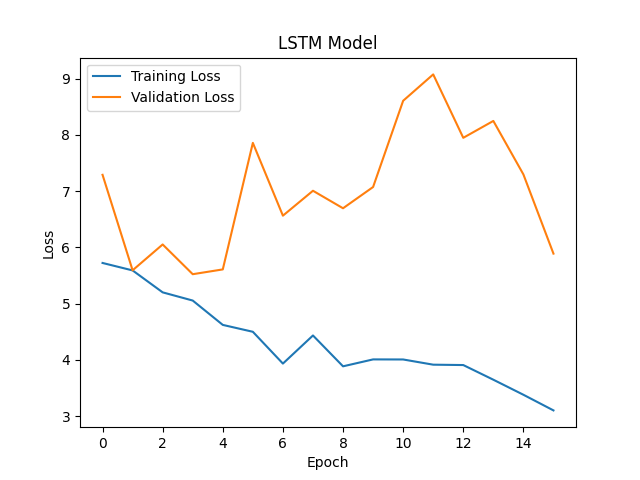

In [17]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.plot(m2_losses['epoch'], m2_losses['train'], label = 'Training Loss')
plt.plot(m2_losses['epoch'], m2_losses['val'], label = 'Validation Loss')
plt.title('LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('Model LSTM.png')

In [18]:
lstm.load_state_dict(torch.load('lstm_model.pt'))

<All keys matched successfully>

In [31]:
# test_sentences = brown.sents()[:25000]#print a few examples of the test sentences
test_sentences = brown.sents()[:25000]#print a few examples of the test sentences

In [32]:
test_sentences = [sentence for sentence in test_sentences if len(sentence) > 6]

In [33]:
cleaned_test_sentences = []
for i in test_sentences:
   
    #use function create_clean to clean the sentences 
    temp = ' '.join(i)
    
    cleaned_test_sentences.append(tokenizer(temp))

In [34]:
lstm.eval()
perplexities = []
final_sent = []
for i in cleaned_test_sentences:
    #create 4-grams from the sentence and store it in a list
    try:
        input_seq = [i[j:j+8] for j in range(len(i)-8)]
        target_seq = i[len(i)-len(input_seq):]
        new_input_seq = []
        for seq in input_seq:
            seqe = []
            for word in seq:
                seqe.append(vocab[word])
            new_input_seq.append(seqe)
        target_seq = [vocab[word] for word in target_seq]
        input_seq = torch.LongTensor(new_input_seq).to(device)
        target_seq = torch.LongTensor(target_seq).to(device)
        output = lstm(input_seq)
        loss = criterion(output, target_seq)
        perplexity = torch.exp(loss)
        perplexity = perplexity.cpu().detach().numpy()
        perplexities.append(perplexity)
        final_sent.append(' '.join(i))
    except:
        pass

In [29]:
perplex = []
with open('2020114017-LSTM-trainperplexity.txt', 'w') as f:
    for i in range(len(perplexities)):
        if perplexities[i] <= len(vocab):
            perplex.append(perplexities[i])
            f.write(final_sent[i] + '\t' + str(perplexities[i]) + '\n')
    f.write('Average perplexity score: ' + str(np.mean(perplex)))